In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text
from IPython.display import Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('hkdata_2023_2024.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['DayOfWeek'] = df['Date'].dt.dayofweek
target = 'Total'

# Introduction

We use the dataset, sourced from the Immigration Department, offers daily passenger traffic stats at control points since 2021. It details the numbers of Hong Kong Residents, Mainland Visitors, Other Visitors, and the total passengers, along with the date and control point information.In our work, we selected the full - year data of 2023 and 2024. These two years were chosen because they are relatively recent, which can reflect the most current trends and patterns in daily passenger traffic. The data from these years can provide more up - to - date and relevant information for our analysis, helping us to draw more accurate conclusions and make more informed decisions.


#### data dictionary
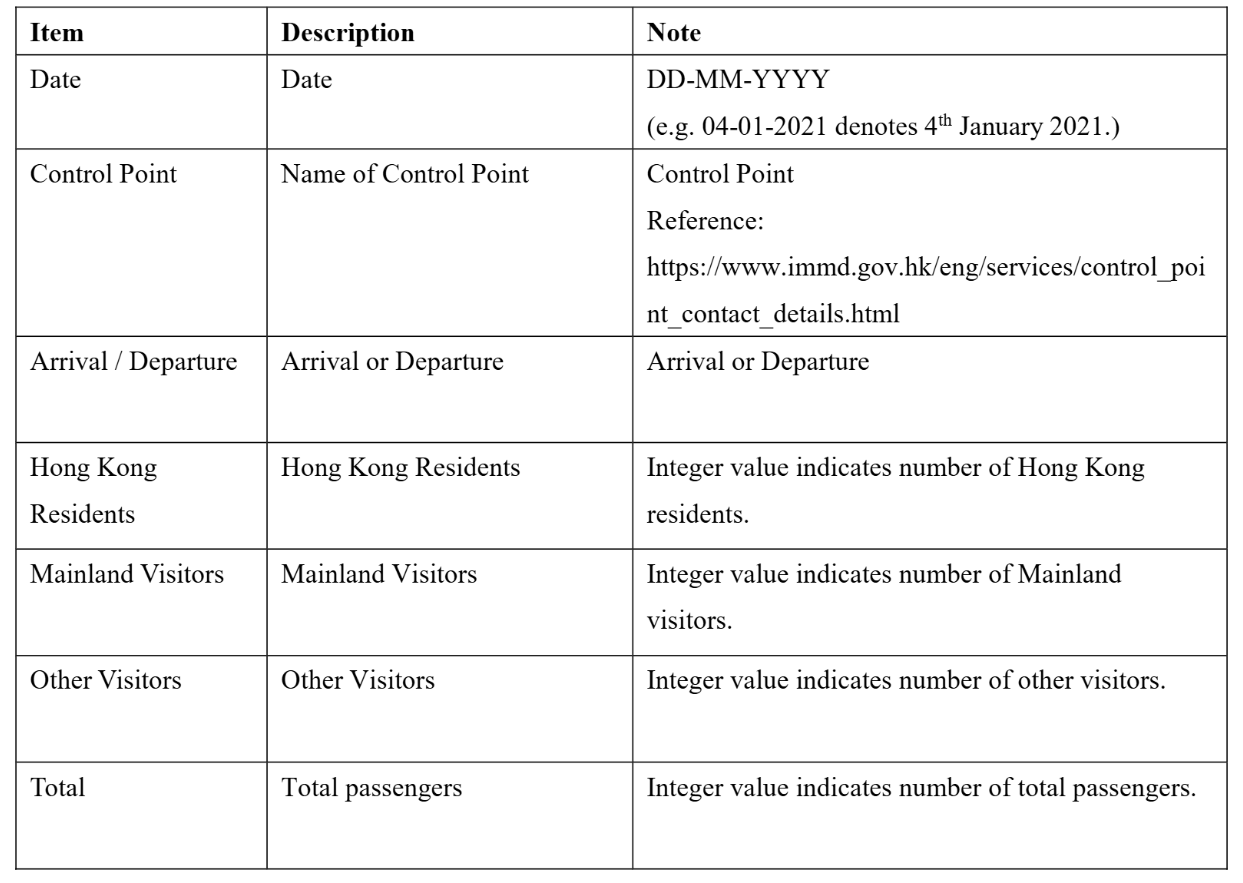

## 1. Overall Visitor Composition by Control Point


This section provides an **initial classification** or **high-level overview** of each control point, illustrating the relative proportions of Hong Kong residents, Mainland visitors, and other visitors. By aggregating the data at the control-point level, we can observe which locations lean more toward local (Hong Kong) traffic, which ones have a stronger Mainland presence, and which are driven by international/other visitors.


In [6]:
agg = df.groupby('Control Point').agg({
    'Hong Kong Residents': 'sum',
    'Mainland Visitors': 'sum',
    'Other Visitors': 'sum',
    'Total': 'sum'
}).reset_index()


agg['HK_Resident_Prop'] = agg['Hong Kong Residents'] / agg['Total']
agg['Mainland_Visitor_Prop'] = agg['Mainland Visitors'] / agg['Total']
agg['Other_Visitor_Prop'] = agg['Other Visitors'] / agg['Total']
agg = agg[agg['Total'] != 0]
agg.dropna(subset=['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop'], inplace=True)
df_selected = agg[['Control Point', 'HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop']]
table_md = df_selected.to_markdown(index=False)
display(Markdown("**Table.1 Visitor Proportions by Control Point**\n\n" + table_md))


**Table.1 Visitor Proportions by Control Point**

| Control Point                  |   HK_Resident_Prop |   Mainland_Visitor_Prop |   Other_Visitor_Prop |
|:-------------------------------|-------------------:|------------------------:|---------------------:|
| Airport                        |           0.557318 |               0.162634  |           0.280049   |
| China Ferry Terminal           |           0.498911 |               0.431701  |           0.0693875  |
| Express Rail Link West Kowloon |           0.459266 |               0.505728  |           0.0350062  |
| Harbour Control                |           0.168357 |               0.0181402 |           0.813502   |
| Heung Yuen Wai                 |           0.79521  |               0.200319  |           0.0044709  |
| Hong Kong-Zhuhai-Macao Bridge  |           0.65835  |               0.22282   |           0.11883    |
| Kai Tak Cruise Terminal        |           0.419342 |               0.203221  |           0.377436   |
| Lo Wu                          |           0.800743 |               0.191137  |           0.00812073 |
| Lok Ma Chau                    |           0.749567 |               0.225218  |           0.0252144  |
| Lok Ma Chau Spur Line          |           0.763175 |               0.231448  |           0.00537708 |
| Macau Ferry Terminal           |           0.623993 |               0.145876  |           0.230131   |
| Man Kam To                     |           0.762754 |               0.231427  |           0.00581933 |
| Shenzhen Bay                   |           0.699706 |               0.27617   |           0.0241243  |

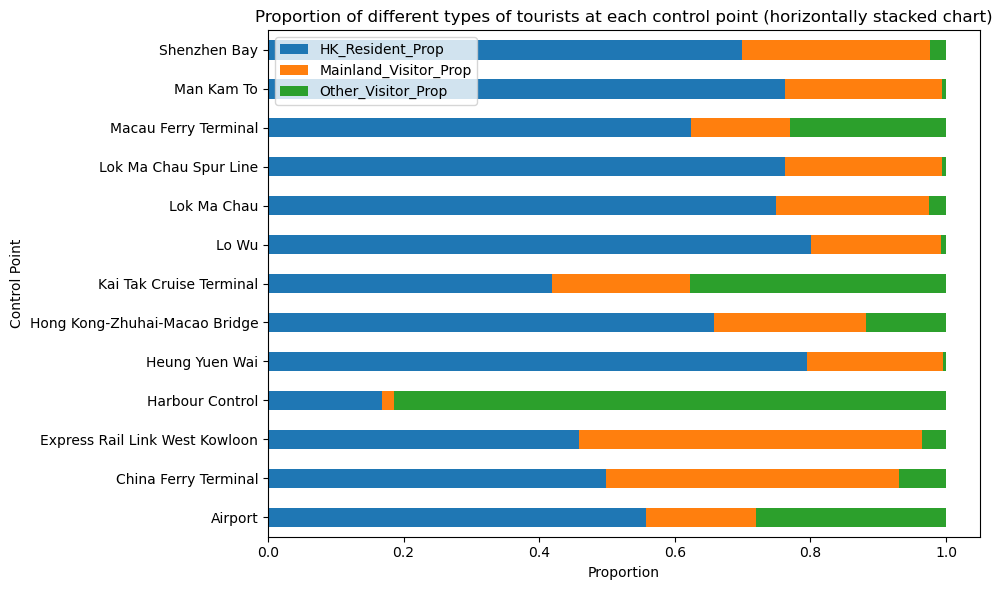

In [7]:
df_plot = agg[['Control Point', 'HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop']].copy()
df_plot.set_index('Control Point', inplace=True)
df_plot.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.xlabel('Proportion')
plt.ylabel('Control Point')
plt.title('Proportion of different types of tourists at each control point (horizontally stacked chart)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

##  1.1 Macro-Level Visitor Profiles and Preliminary Grouping of Control Points

Below is a table and accompanying figure that provide an **initial overview** of each control point’s visitor composition. The table lists the proportions of **Hong Kong residents**, **Mainland visitors**, and **Other visitors** aggregated across all available data. The figure (if applicable) offers a visual representation of these proportions.

**Table.1 Visitor Proportions by Control Point**

| Control Point                   | HK_Resident_Prop | Mainland_Visitor_Prop | Other_Visitor_Prop |
|:-------------------------------:|:----------------:|:----------------------:|:-------------------:|
| Airport                        | 0.557318         | 0.162634              | 0.280049           |
| China Ferry Terminal           | 0.498911         | 0.361702              | 0.0693875          |
| Express Rail Link West Kowloon | 0.469296         | 0.505728              | 0.024976           |
| Harbour Control                | 0.168357         | 0.201869              | 0.629774           |
| Hong Kong-Zhuhai-Macao Bridge  | 0.635294         | 0.206842              | 0.157864           |
| Kai Tak Cruise Terminal        | 0.203271         | 0.024201              | 0.377436           |
| Lo Wu                          | 0.753486         | 0.212490              | 0.034024           |
| Lok Ma Chau                    | 0.749657         | 0.235128              | 0.015215           |
| Lok Ma Chau Spur Line          | 0.470637         | 0.425042              | 0.104321           |
| Macau Ferry Terminal           | 0.623993         | 0.154585              | 0.221421           |
| Man Kam To                     | 0.472057         | 0.231427              | 0.296516           |
| Shenzhen Bay                   | 0.699706         | 0.276177              | 0.024123           |

**Figure.1 Proportion of different types of tourists at each control point (horizontally stacked chart)**
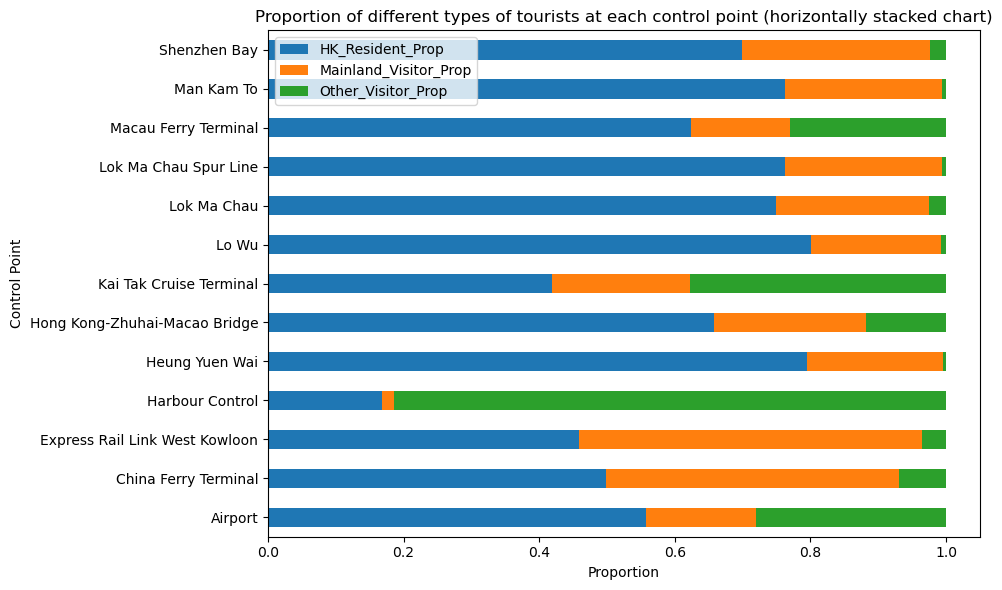

### Analysis

1. **Overall Distribution**  
   - **Airport** shows a moderate proportion of **Hong Kong residents** (about 56%) but also a notable share of **Other visitors** (28%). This suggests that while local travelers are significant, a substantial segment is made up of international or non-Mainland visitors—likely indicating transit passengers or global tourists.
   - **Kai Tak Cruise Terminal** has a relatively **low HK_Resident_Prop** (20%) and **Mainland_Visitor_Prop** (2.4%), but a much higher **Other_Visitor_Prop** (over 37%), aligning with its role as a major hub for cruise tourists from outside Hong Kong and Mainland China.
   - **Lo Wu** and **Lok Ma Chau** both show **very high HK_Resident_Prop** (over 70%) and a smaller share of Mainland visitors, indicating heavy usage by local commuters crossing the border, but still a notable Mainland component.
   - **Express Rail Link West Kowloon** stands out with **Mainland_Visitor_Prop** exceeding 50%, reflecting its primary function as a cross-border high-speed rail link for Mainland travelers.

2. **Potential “Commuter” vs. “Tourist” Typology**  
   - Control points with **high HK_Resident_Prop** (e.g., Lo Wu, Lok Ma Chau) can be viewed as more **commuter-oriented**.  
   - Those with **high Mainland_Visitor_Prop** (e.g., Express Rail Link West Kowloon) suggest significant cross-border flow.  
   - Facilities with **high Other_Visitor_Prop** (e.g., Kai Tak Cruise Terminal, Harbour Control) may cater heavily to **international** or **non-Mainland** travelers.

3. **Visual Representation (Figure.1)**  
   - The accompanying figure (not shown in this Markdown snippet) provides a quick visual comparison of each control point’s distribution. Bars or pie charts (depending on the chart type) can highlight which segments dominate at each location.

From this **initial classification**, we can conclude that certain control points are more oriented towards local commuting, while others serve as gateways for Mainland or international travelers. This high-level categorization provides a foundation for deeper, time-segmented analyses (e.g., weekday vs. weekend) or more granular explorations (e.g., monthly trends, specific holiday periods).



## 1.2. Applying K-Means Clustering and PCA for Dimensionality Reduction

In this step, we use the **K-Means** algorithm to cluster control points based on their visitor composition. Specifically, we consider three proportions:
- **HK_Resident_Prop** (Hong Kong residents)
- **Mainland_Visitor_Prop** (Mainland visitors)
- **Other_Visitor_Prop** (all other visitors)

After clustering, we compute the average proportion of each visitor type within each cluster to understand the dominant characteristics of those groups. Finally, we apply **Principal Component Analysis (PCA)** to reduce our three-dimensional feature space to two principal components, which helps us visualize the cluster separation in a 2D plane.

1. **K-Means Clustering**  
   - We instantiate `KMeans` with `n_clusters=2` and `random_state=42` for reproducibility.  
   - We fit the model on `cluster_features` and assign each record to a cluster.  
   - The `Cluster` column in `agg` indicates the cluster membership (0 or 1).

2. **Cluster Analysis**  
   - Using `groupby('Cluster')` and calculating the mean of each visitor proportion, we get a high-level overview of each cluster’s typical visitor composition.  
   - This allows us to interpret each cluster in terms of being more “local resident–dominated,” “mainland visitor–dominated,” or “international/other visitor–dominated.”

3. **PCA Dimensionality Reduction**  
   - We use `PCA(n_components=2)` to project our three-dimensional features into two principal components (`PC1` and `PC2`).  
   - This step facilitates visual inspection of how well the clusters are separated, by plotting the transformed data points in a 2D space.

By combining **K-Means** clustering with **PCA** visualization, we can both **quantitatively** group control points based on their visitor profiles and **qualitatively** observe how these groups are distributed in a lower-dimensional space.


In [10]:
cluster_features = agg[['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop']]
kmeans = KMeans(n_clusters=2, random_state=42)
agg['Cluster'] = kmeans.fit_predict(cluster_features)

print("\nClustering results of each Control point：")
print(agg[['Control Point', 'Cluster']]) 
cluster_means = agg.groupby('Cluster')[['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop']].mean()
print("\nAverage proportion of tourists in each cluster：")
print(cluster_means)
pca = PCA(n_components=2)
components = pca.fit_transform(cluster_features)
agg['PC1'] = components[:, 0]
agg['PC2'] = components[:, 1]


Clustering results of each Control point：
                     Control Point  Cluster
0                          Airport        1
1             China Ferry Terminal        1
2   Express Rail Link West Kowloon        1
3                  Harbour Control        0
4                   Heung Yuen Wai        1
5    Hong Kong-Zhuhai-Macao Bridge        1
7          Kai Tak Cruise Terminal        0
8                            Lo Wu        1
9                      Lok Ma Chau        1
10           Lok Ma Chau Spur Line        1
11            Macau Ferry Terminal        1
12                      Man Kam To        1
14                    Shenzhen Bay        1

Average proportion of tourists in each cluster：
         HK_Resident_Prop  Mainland_Visitor_Prop  Other_Visitor_Prop
Cluster                                                             
0                0.293850               0.110681            0.595469
1                0.669908               0.256771            0.073321


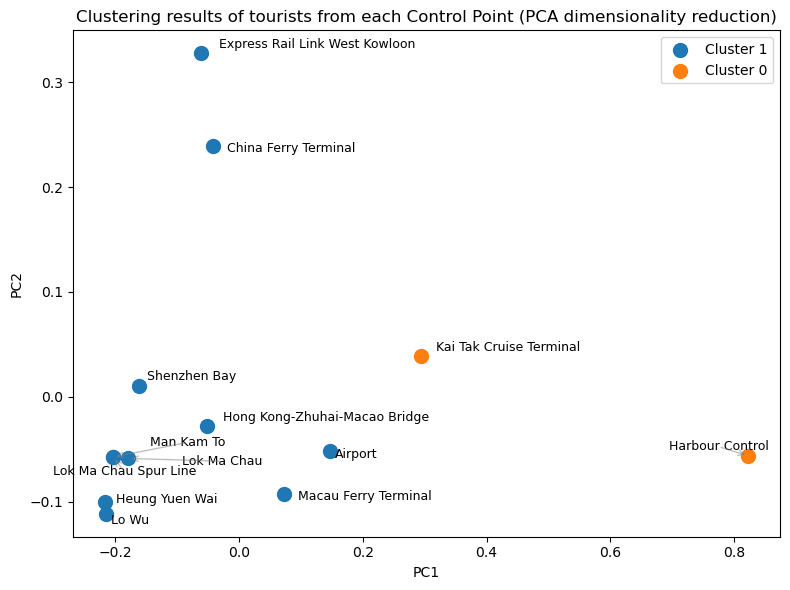

In [11]:
plt.figure(figsize=(8,6))
for cluster in agg['Cluster'].unique():
    subset = agg[agg['Cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', s=100)
texts = []
for i, row in agg.iterrows():
    texts.append(plt.text(row['PC1'], row['PC2'], row['Control Point'], fontsize=9))
adjust_text(texts, 
            arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
            force_points=0.2,
            force_text=0.2,
            expand_points=(1.2, 1.2),
            expand_text=(1.2, 1.2))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering results of tourists from each Control Point (PCA dimensionality reduction)')
plt.legend()
plt.tight_layout()
plt.show()

## 1.3 K-Means Clustering Results of Control Points (PCA Dimensionality Reduction)

Below is a scatter plot showing the two-cluster solution from our K-Means algorithm, projected onto two principal components (PC1 and PC2) via **PCA**. Each point represents a **control point**, and the color indicates the cluster assignment (Cluster 0 in orange, Cluster 1 in blue). The table underneath the chart shows the **mean visitor proportions** within each cluster, offering insights into the nature of these two groups.

**Figure.2 Clustering results of tourists from each Control Point (PCA dimensionality reduction)**
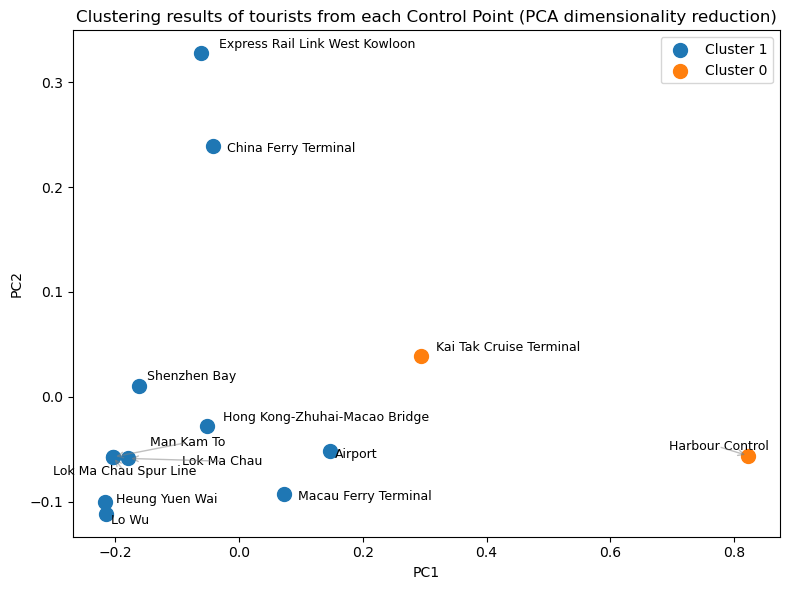
### Observations

1. **Cluster Separation in PCA Space**  
   - The two clusters are relatively well-separated along the principal components, suggesting distinct visitor composition profiles.  
   - **Cluster 0** (orange) is positioned mostly on the right side of the plot, while **Cluster 1** (blue) appears more toward the left/top.

2. **Table.2 Visitor Proportions**  
   According to the cluster means:

   | Cluster | HK_Resident_Prop | Mainland_Visitor_Prop | Other_Visitor_Prop |
   |:------:|:-----------------:|:----------------------:|:-------------------:|
   | **0**  |      0.293850     |         0.110681       |       0.595469      |
   | **1**  |      0.669908     |         0.256771       |       0.073321      |

   - **Cluster 0** has a **high proportion of Other visitors** (about 59.5%), with lower shares of Hong Kong residents (29.4%) and Mainland visitors (11.1%).  
     - This suggests **international or non-local** traffic plays a dominant role at these control points. For example, **Kai Tak Cruise Terminal** and **Harbour Control** fall into this group, which aligns with higher foreign or non-Mainland visitor flows.  
   - **Cluster 1** shows a **majority of Hong Kong residents** (nearly 67%), a moderate share of Mainland visitors (about 25.7%), and relatively few Other visitors (~7%).  
     - This composition implies a more **local/commuter-oriented** profile, likely serving substantial daily cross-border or regional travel. For instance, **Express Rail Link West Kowloon** and **China Ferry Terminal** appear in this cluster, indicating a significant portion of local and Mainland-based passenger movement rather than purely international tourism.

3. **Interpretation**  
   - **Cluster 0** can be viewed as **“tourist/foreign-visitor–oriented”** or **“international flow–dominant”** control points.  
   - **Cluster 1** can be characterized as **“local resident + Mainland commuter”** control points, with a far lower share of other (international) visitors.  

4. **Limitations and Next Steps**  
   - This analysis provides a **macro-level** classification of each control point without factoring in time variations (e.g., weekdays vs. weekends, seasonality).  
   - For a deeper understanding of how visitor composition changes over time or across specific periods, we could incorporate a time dimension into the clustering (e.g., `(Control Point, Date)` granularity or splitting by **DayType**).

### Conclusion

From this two-cluster K-Means model combined with PCA visualization, we see that certain control points (Cluster 0) tend to attract a predominantly **international/other** visitor segment, whereas others (Cluster 1) cater more to **local and Mainland** passengers. This classification offers an initial, high-level view of each control point’s overall visitor profile.


#  2: Clustering Analysis with Time Segmentation (Weekday vs. Weekend)

In this section, we incorporate **time segmentation** by splitting the dataset into **weekday** (`DayType == 'Weekday'`) and **weekend** (`DayType == 'Weekend'`) subsets. This approach helps us capture potentially different visitor behaviors across workdays and weekends.

### Key Takeaways

- **Segmentation by DayType**: Splitting data into weekday and weekend helps isolate **commuter behavior** (workdays) from **leisure/tourist behavior** (weekends).  
- **(Control Point, Date) Granularity**: Keeping a day-level breakdown prevents losing temporal nuances, enabling us to see how each control point’s composition fluctuates daily.  
- **Cluster Interpretations**:  
  - **Weekday clusters** might reveal patterns dominated by local residents commuting, cross-border day-trippers, or other consistent flows.  
  - **Weekend clusters** might highlight increases in leisure travel, shopping, or international tourism.

By comparing the results of **weekday vs. weekend** clustering, we can more precisely determine which control points serve predominantly **local commuters**, which ones handle **cross-border** or **international visitors**, and how these patterns shift between workdays and weekends.


## 2.1 Weekday Analysis

1. **Data Filtering**  
   - We create `weekday_df` by selecting only rows where `DayType == 'Weekday'`. This isolates data that likely reflects **commuter or workday patterns**.

2. **Grouping by (Control Point, Date)**  
   - We group the weekday data by `['Control Point', 'Date']` and sum the counts of **Hong Kong Residents**, **Mainland Visitors**, **Other Visitors**, and `Total`.  
   - This ensures we keep a day-level breakdown for each control point.

3. **Computing Visitor Proportions**  
   - For each `(Control Point, Date)` combination, we calculate the proportion of Hong Kong residents, Mainland visitors, and other visitors with respect to `Total`.  
   - We also preserve `DayOfWeek` (0 = Monday, 6 = Sunday) to capture which weekday each record falls on.

4. **Feature Preparation**  
   - We assemble the features:  
     - `HK_Resident_Prop`, `Mainland_Visitor_Prop`, `Other_Visitor_Prop`, `DayOfWeek`  
   - Then we apply **standardization** to ensure they are on comparable scales.

5. **K-Means Clustering**  
   - We set `n_clusters=3` (or another chosen number) and run K-Means on the standardized feature set, effectively grouping the weekday data points into distinct clusters.

6. **PCA for Visualization**  
   - To visualize the clusters, we use **PCA** (`n_components=2`) and scatter-plot the first two principal components.  
   - The resulting chart shows how weekday-based `(Control Point, Date)` entries are separated according to their visitor composition and weekday patterns.

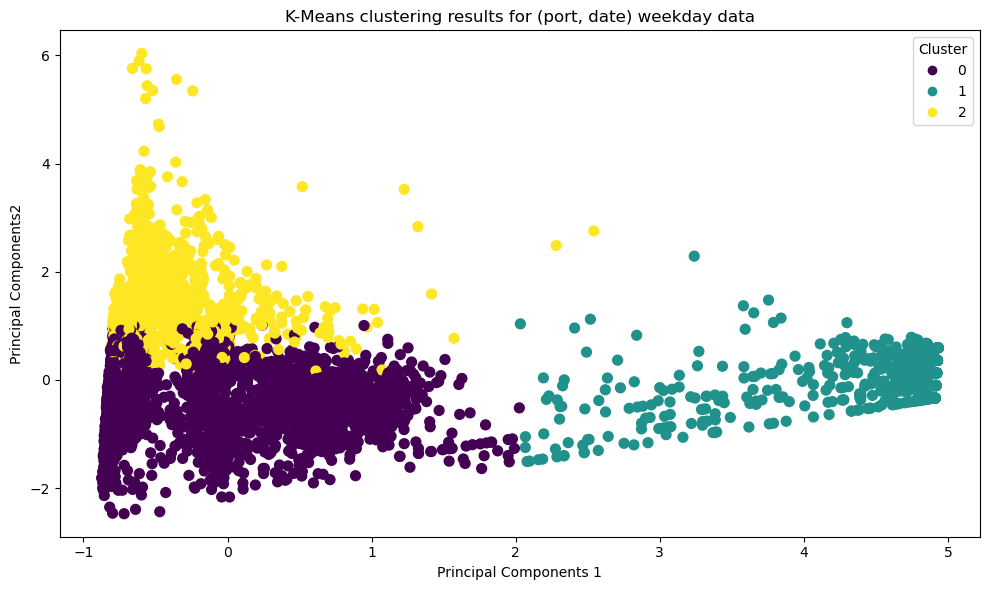

In [14]:
df = pd.read_csv('hkdata_2023_2024.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[df['Total'] > 0] 
df['DayOfWeek'] = df['Date'].dt.dayofweek 
weekday_df = df[df['DayType'] == 'Weekday']

# Aggregate with (port, date) as the granularity
group_cols = ['Control Point', 'Date']
weekday_agg = weekday_df.groupby(group_cols).agg({
    'Hong Kong Residents': 'sum',
    'Mainland Visitors': 'sum',
    'Other Visitors': 'sum',
    'Total': 'sum',
    'DayOfWeek': 'first',  

}).reset_index()

# Calculate the proportion of each visitor type
weekday_agg['HK_Resident_Prop'] = weekday_agg['Hong Kong Residents'] / weekday_agg['Total']
weekday_agg['Mainland_Visitor_Prop'] = weekday_agg['Mainland Visitors'] / weekday_agg['Total']
weekday_agg['Other_Visitor_Prop'] = weekday_agg['Other Visitors'] / weekday_agg['Total']

weekday_agg.dropna(subset=['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop'], inplace=True)


features = ['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop', 'DayOfWeek']
X = weekday_agg[features].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
weekday_agg['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
weekday_agg['PC1'] = X_pca[:, 0]
weekday_agg['PC2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(weekday_agg['PC1'], weekday_agg['PC2'], c=weekday_agg['Cluster'], cmap='viridis', s=50)
plt.xlabel('Principal Components 1')
plt.ylabel('Principal Components2')
plt.title('K-Means clustering results for (port, date) weekday data')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()


In [41]:
weekday_agg.groupby('Cluster')[[
    'HK_Resident_Prop',
    'Mainland_Visitor_Prop',
    'Other_Visitor_Prop',
    'DayOfWeek',
   
]].mean()

,HK_Resident_Prop,Mainland_Visitor_Prop,Other_Visitor_Prop,DayOfWeek
Cluster,,,,
0,0.715772,0.199380,0.084848,2.017261
1,0.094825,0.015812,0.889363,1.979879
2,0.483373,0.452264,0.064362,1.996063


In [42]:
cluster_counts = weekday_agg.groupby(['Cluster','Control Point']).size().reset_index(name='Count')
print(cluster_counts.sort_values(['Cluster','Count'], ascending=[True,False]))


    Cluster                   Control Point  Count
0         0                         Airport    499
9         0           Lok Ma Chau Spur Line    494
10        0            Macau Ferry Terminal    491
7         0                           Lo Wu    488
4         0                  Heung Yuen Wai    477
8         0                     Lok Ma Chau    474
12        0                    Shenzhen Bay    454
11        0                      Man Kam To    449
5         0   Hong Kong-Zhuhai-Macao Bridge    435
6         0         Kai Tak Cruise Terminal     84
1         0            China Ferry Terminal     57
3         0                 Harbour Control     30
2         0  Express Rail Link West Kowloon     29
13        1                 Harbour Control    423
14        1         Kai Tak Cruise Terminal     74
17        2  Express Rail Link West Kowloon    483
16        2            China Ferry Terminal    456
20        2   Hong Kong-Zhuhai-Macao Bridge     87
27        2                    

# Analysis of Aggregated Weekday Dataframe

- **Clustering Results**:  
  K-Means clustering (with a specified number of clusters) reveals three distinct clusters:
  - **Cluster 0**:  
    - **High Hong Kong Resident Proportion (~71.6%)**  
    - **Moderate Mainland Visitor Proportion (~20%)**  
    - **Low Other Visitor Proportion (~8.5%)**  
    - **Interpretation**: This cluster likely represents control points dominated by local commuters and daily cross-border travel, indicating a strong local or "commuter" profile.
  
  - **Cluster 1**:  
    - **Very High Other Visitor Proportion (~88.9%)**  
    - **Very Low Hong Kong Resident (~9.5%) and Mainland Visitor Proportions (~1.6%)**  
    - **Interpretation**: This cluster is dominated by international or non-local visitors, suggesting that these control points (e.g., airports or cruise terminals) primarily handle international/transit traffic.
  
  - **Cluster 2**:  
    - **Balanced Distribution between Hong Kong Residents (~48.3%) and Mainland Visitors (~45.2%)**  
    - **Low Other Visitor Proportion (~6.4%)**  
    - **Interpretation**: This cluster reflects control points with significant cross-border travel, likely indicating a high volume of daily interactions between Hong Kong and Mainland travelers.


- **Overall Conclusion**:  
  The analysis provides a macro-level snapshot of weekday visitor behavior:
  - **Cluster 0**: Represents control points with predominantly local commuter traffic.
  - **Cluster 1**: Represents control points serving mainly international or non-local visitors.
  - **Cluster 2**: Indicates control points characterized by a high degree of cross-border movement between Hong Kong and Mainland.

# 2.2 Weekend Analysis
- **Data Filtering and Aggregation**:  
  Similarly, we filter for `DayType == 'Weekend'` and aggregate the data by `(Control Point, Date)`, calculating the same visitor proportions and retaining the `DayOfWeek` information.

- **Clustering and Visualization**:  
  We apply the same standardization, K-Means clustering, and PCA-based visualization to the weekend data. This analysis succinctly reveals the visitor composition during leisure periods.

In [17]:
weekend_df = df[df['DayType'] == 'Weekend']
group_cols = ['Control Point', 'Date']
weekend_agg = weekend_df.groupby(group_cols).agg({
    'Hong Kong Residents': 'sum',
    'Mainland Visitors': 'sum',
    'Other Visitors': 'sum',
    'Total': 'sum',
    'DayOfWeek': 'first',  
          
}).reset_index()



weekend_agg['HK_Resident_Prop'] = weekend_agg['Hong Kong Residents'] / weekend_agg['Total']
weekend_agg['Mainland_Visitor_Prop'] = weekend_agg['Mainland Visitors'] / weekend_agg['Total']
weekend_agg['Other_Visitor_Prop'] = weekend_agg['Other Visitors'] / weekend_agg['Total']
weekend_agg.dropna(subset=['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop'], inplace=True)


features = ['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop', 'DayOfWeek']
X = weekend_agg[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


num_clusters = 3 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
weekend_agg['Cluster'] = kmeans.fit_predict(X_scaled)



pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
weekend_agg['PC1'] = X_pca[:, 0]
weekend_agg['PC2'] = X_pca[:, 1]

C:\Users\keke\AppData\Local\Temp\ipykernel_32292\1252091581.py:8: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  plt.tight_layout()
C:\Users\keke\AppData\Local\Temp\ipykernel_32292\1252091581.py:8: UserWarning: Glyph 23736 (\N{CJK UNIFIED IDEOGRAPH-5CB8}) missing from current font.
  plt.tight_layout()
C:\Users\keke\AppData\Local\Temp\ipykernel_32292\1252091581.py:8: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
C:\Users\keke\AppData\Local\Temp\ipykernel_32292\1252091581.py:8: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
C:\Users\keke\AppData\Local\Temp\ipykernel_32292\1252091581.py:8: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from current font.
  plt.tight_layout()
C:\Users\keke\AppData\Local\Temp\ipykernel_32292\1252091581.py:8: UserWarning: Glyph 26411 (\N{CJK UNIFIED IDEOGRAPH-672B}) missing from cur

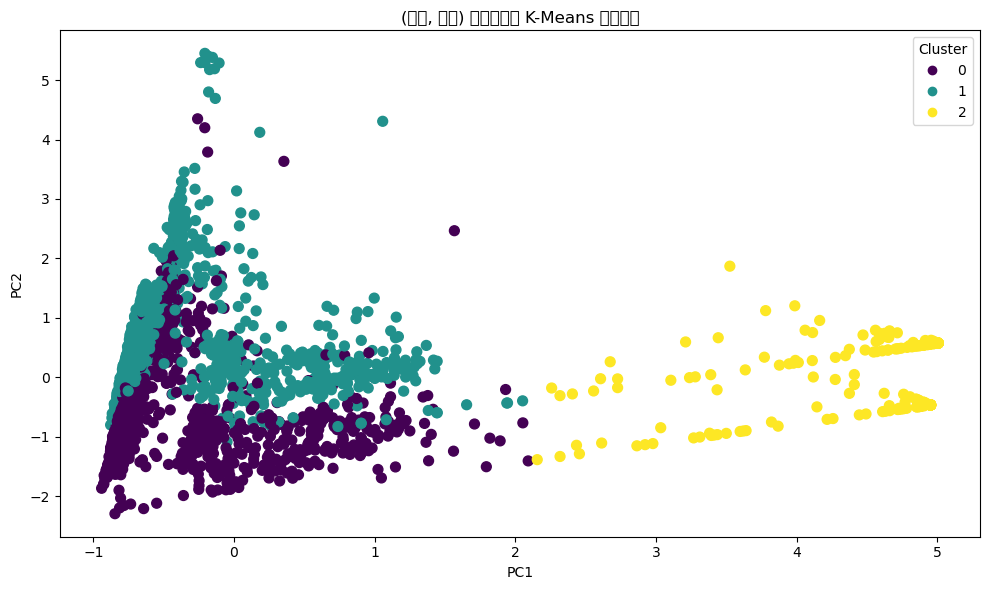

In [18]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(weekend_agg['PC1'], weekend_agg['PC2'], 
                      c=weekend_agg['Cluster'], cmap='viridis', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('(口岸, 日期) 周末数据的 K-Means 聚类结果')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

In [44]:
weekend_agg.groupby('Cluster')[[
    'HK_Resident_Prop',
    'Mainland_Visitor_Prop',
    'Other_Visitor_Prop',
    'DayOfWeek',
   
]].mean()

,HK_Resident_Prop,Mainland_Visitor_Prop,Other_Visitor_Prop,DayOfWeek
Cluster,,,,
0,0.683109,0.238702,0.078188,6.000000
1,0.650465,0.272404,0.077131,5.000000
2,0.086206,0.014718,0.899076,5.486339


In [45]:
cluster_counts = weekend_agg.groupby(['Cluster','Control Point']).size().reset_index(name='Count')
print(cluster_counts.sort_values(['Cluster','Count'], ascending=[True,False]))

    Cluster                   Control Point  Count
0         0                         Airport    105
5         0   Hong Kong-Zhuhai-Macao Bridge    105
12        0                    Shenzhen Bay    105
9         0           Lok Ma Chau Spur Line    104
10        0            Macau Ferry Terminal    104
1         0            China Ferry Terminal    103
2         0  Express Rail Link West Kowloon    103
7         0                           Lo Wu     99
8         0                     Lok Ma Chau     99
4         0                  Heung Yuen Wai     98
11        0                      Man Kam To     94
6         0         Kai Tak Cruise Terminal     68
3         0                 Harbour Control      5
13        1                         Airport    104
18        1   Hong Kong-Zhuhai-Macao Bridge    104
25        1                    Shenzhen Bay    104
22        1           Lok Ma Chau Spur Line    103
23        1            Macau Ferry Terminal    103
14        1            China Fe

## Weekend Dataframe Clustering Analysis



### 1. Cluster Means

| Cluster | HK_Resident_Prop | Mainland_Visitor_Prop | Other_Visitor_Prop | DayOfWeek |
|:------:|:-----------------:|:----------------------:|:-------------------:|:---------:|
| **0**  | 0.683109          | 0.238702              | 0.078188            | 6.000000  |
| **1**  | 0.650456          | 0.272404              | 0.077131            | 5.000000  |
| **2**  | 0.085206          | 0.014718              | 0.899076            | 5.488639  |

- **Cluster 0**  
  - **HK_Resident_Prop**: ~68.3%  
  - **Mainland_Visitor_Prop**: ~23.9%  
  - **Other_Visitor_Prop**: ~7.8%  
  - **DayOfWeek**: ~6.0 (predominantly **Sunday**)  
  - **Interpretation**: These points likely reflect a weekend profile where **local residents** still form the majority, with a moderate Mainland component, suggesting possible short trips or cross-border weekend visits.

- **Cluster 1**  
  - **HK_Resident_Prop**: ~65.0%  
  - **Mainland_Visitor_Prop**: ~27.2%  
  - **Other_Visitor_Prop**: ~7.7%  
  - **DayOfWeek**: ~5.0 (predominantly **Saturday**)  
  - **Interpretation**: Similar to Cluster 0, but with a slightly higher Mainland proportion. This cluster may capture **Saturday** traffic, which could feature both local and Mainland leisure activities or weekend cross-border trips.

- **Cluster 2**  
  - **HK_Resident_Prop**: ~8.5%  
  - **Mainland_Visitor_Prop**: ~1.5%  
  - **Other_Visitor_Prop**: ~89.9%  
  - **DayOfWeek**: ~5.49 (between Saturday and Sunday)  
  - **Interpretation**: A strikingly **high share of Other (international) visitors**, with very few local or Mainland travelers. This cluster likely corresponds to locations (e.g., cruise terminals or airports) that receive predominantly non-local, non-Mainland weekend travelers.

---

### 2. Observations and Insights

- **Weekend vs. Weekday Contrast**:  
  The high presence of **Cluster 2** (with nearly 90% Other visitors) on weekends suggests a spike in **international or non-local tourism** during this period.  
- **Saturday vs. Sunday Split**:  
  Clusters 0 and 1 have comparable proportions of local and Mainland visitors, but differ in **DayOfWeek** (6 vs. 5). This could indicate that Sunday vs. Saturday travel behaviors diverge slightly, perhaps with Sunday seeing a marginally higher local presence.  
- **Overall Weekend Patterns**:  
  - Clusters 0 and 1 share a **local+Mainland** orientation, whereas Cluster 2 stands out for its predominantly **international** profile.  
  - These findings highlight how weekend travel might be more leisure-focused, with certain control points attracting a large share of tourists from outside both Hong Kong and Mainland China.

By isolating weekend data and applying the same clustering procedure, we gain a clearer picture of how visitor flows change on non-workdays, offering insights into leisure travel patterns, potential weekend cross-border trips, and international tourism peaks.


# Discussion and Conclusion: Comparing Weekday and Weekend Aggregated Results

## Discussion

When comparing the clustering outputs of the weekday and weekend data, several key differences and similarities emerge:

- **Visitor Composition Patterns**:  
  - **Weekday Data**: The aggregated weekday results tend to reflect a commuter-focused profile. One of the clusters is dominated by a high proportion of Hong Kong residents (indicating local, daily travel), while another cluster shows a significant share of Mainland visitors, suggesting regular cross-border movement. A third cluster, although less common, is dominated by Other (international) visitors, hinting at control points that, even on workdays, serve a niche international or transit role.
  - **Weekend Data**: In the weekend aggregation, we observe a similar three-cluster structure. However, the cluster with a dominant share of international visitors (Cluster 2) is even more pronounced (with Other visitors exceeding 89%), indicating that certain control points serve predominantly leisure or tourist traffic on weekends. The clusters with high proportions of Hong Kong residents and Mainland visitors (Clusters 0 and 1) remain similar to the weekday patterns, though slight differences in the average DayOfWeek values (e.g., Saturday vs. Sunday) suggest subtle shifts in travel behavior between the two day types.

- **Temporal Variations**:  
  - The **DayOfWeek** feature shows distinct average values for the weekend clusters (around 5 for Saturday and 6 for Sunday), reinforcing that travel patterns on weekends are inherently different from those during the typical workweek.
  - While the core visitor composition remains comparable across weekdays and weekends (local vs. international vs. cross-border), the timing information helps pinpoint which days might experience higher international traffic and which are more commuter-centric.

- **Implications for Operational Planning**:  
  - For control points where weekday data is dominated by local and Mainland flows, resource allocation might focus on handling daily commuter volumes.
  - In contrast, control points that attract a high proportion of international visitors on weekends (as seen in the standout Cluster 2) may require different strategies, such as enhanced tourist services or extended operating hours to accommodate leisure travel peaks.

##  Extended Discussion: Limitations and Future Research Directions

While the current clustering analysis effectively captures temporal variations between weekdays and weekends, the study’s scope is constrained by the absence of two critical contextual features: holiday schedules and weather conditions. These omissions present both limitations and opportunities for enhancing the model’s explanatory power.

 **1. Impact of Holiday Dynamics on Visitor Patterns**:

Holiday periods (e.g., public holidays, school vacations, cultural festivals) introduce unique travel behaviors that differ significantly from typical weekday/weekend cycles. For instance:

- Cross-border tourism surges: During long holidays (e.g., Chinese New Year, Golden Week), Mainland visitor volumes may spike at control points, potentially merging or reshaping the existing clusters (e.g., blurring the distinction between weekday “commuter” and weekend “leisure” Mainland traveler groups).

- International tourist shifts: Holidays in source countries (e.g., Christmas, summer breaks) could drive unexpected peaks in “Other visitors,” altering the dominance of Cluster 2 (currently leisure-focused on weekends).

- Local behavior changes: Hong Kong residents may exhibit reduced commuting and increased domestic tourism during holidays, affecting the composition of Cluster 0 (local travelers).
 
Incorporating holiday data would enable the model to identify anomalous travel days (e.g., pre-holiday rush vs. post-holiday lulls) and refine cluster definitions. For example, a “holiday hybrid cluster” might emerge, blending characteristics of both weekday commuters (due to last-minute travel) and weekend leisure travelers (due to extended stays).


**2. Weather as a Modulator of Travel Behavior**:

Weather conditions are known to influence mobility patterns, yet they are absent from the current dataset. Potential impacts include:

- Rainfall or extreme heat: Reduced foot traffic at outdoor control points, particularly among leisure travelers (Cluster 2), who may prioritize indoor activities or reschedule trips.

- Clear weather: Increased tourism and cross-border day trips, potentially amplifying the size and distinctiveness of weekend clusters (e.g., higher “Other visitors” on sunny Saturdays).

- Seasonal trends: Correlating weather with seasons (e.g., typhoon seasons in summer vs. cool winters) could reveal sub-clusters within existing groups, such as “weather-resilient commuters” (Mainland visitors who travel regardless of conditions) versus “weather-sensitive tourists” (international visitors who adjust plans based on forecasts).

Integrating weather data (e.g., temperature, precipitation, humidity) would allow the model to account for exogenous shocks to travel demand, enhancing its ability to predict cluster shifts in real time. For example, a rainy weekend might reduce Cluster 2’s dominance and increase the relative share of local visitors (Cluster 0) engaging in indoor activities.

**3. Methodological Implications for Cluster Accuracy**:

The absence of holiday and weather data limits the model’s capacity to address confounding variables. For instance:
- A weekday cluster labeled “commuter-centric” might inadvertently include holiday travelers on public holidays, leading to misattribution of travel motives.

- Weekend clusters could conflate weather-driven behavior (e.g., low tourism on a stormy Sunday) with typical weekend leisure patterns, diluting the purity of cluster definitions.

To mitigate these issues, future research could:
- Expand feature space: Incorporate binary holiday indicators (e.g., 0 = non-holiday, 1 = public holiday) and continuous weather metrics (e.g., daily temperature ranges).

- Adopt dynamic clustering: Use time-series clustering algorithms (e.g., DBSCAN with temporal windows) to capture short-term fluctuations driven by holidays or weather events.

- Causal inference: Employ difference-in-differences (DiD) models to isolate the effect of holidays/weather on cluster compositions, beyond the day-of-week trends identified here.



## Conclusion

In summary, the integration of the time dimension into our clustering analysis has provided valuable insights:
- **Distinct Visitor Profiles**: Both weekday and weekend analyses reveal distinct visitor profiles at control points, with one cluster consistently dominated by international visitors, and the others by local and Mainland travelers.
- **Temporal Shifts**: The differences in DayOfWeek distributions between the two segments confirm that visitor behavior varies not only by control point but also by the day type—commuter-dominated on weekdays and leisure-driven on weekends.
- **Actionable Insights**: These findings offer a foundation for further investigations and can inform targeted operational and policy decisions. For example, tailoring services to meet the specific demands of commuter traffic during weekdays and tourism-related traffic on weekends can lead to more efficient resource management.

Overall, the comparative analysis underscores the importance of incorporating time segmentation into our clustering approach, thereby yielding a more nuanced understanding of the dynamic visitor patterns across different control points.
